# COGS 108 - Final Project 

# Overview

In this project, I used data from yelp ratings of parks and PM2.5 percentiles in air around parks in San Diego, trying to explore the relationship between them. At the end of the study, I found a slightly negative relationship between park ratings and PM2.5 percentiles in San Deigo, suggesting that the higher rating a park is, the better air quality the park has.

# Names & GitHub ID

- Name: Mincheng Wang
- GitHub Username: MChengW

# Research Question

Do well-developed parks in San Diego with high yelp ratings have less PM2.5 percentiles in air than the ones with low yelp ratings?



## Background and Prior Work

San Diego, with its great weather, miles of sandy beaches, and major attractions, is known worldwide as one of the best tourist destinations and a great place for residents to relax year round. It has 57 Recreation Centers, 13 Pools, 7 Skate Parks, and more than 340 parks and 25 miles of shoreline from Sunset Cliffs to La Jolla [1]. Many evidence propose that there might be a strong relationship between well-developed parks and air qualities around them. For example, natural plants, trees, or other greenry can help absorb harmful air pollution and disturbing noise [2]. They help reduce air pollution both by directly removing pollutants and by reducing air temperatures and building energy use in and near parks[3]. In addition to the direct effect of how plants can reduce pollution,helping the community build its own park helps residents gain the confidence to address long-standing environmental challenges[4].

My study then will collect and analyze data to examine whether those parks in San Diego with high popularities tend to have better air qualities as well, focusing on the relationship between the yelp ratings of those parks and their PM2.5 percentiles.  

References (include links):

- 1)https://www.sandiego.gov/park-and-recreation/parks


- 2)https://www.nbcnews.com/health/health-news/living-near-green-spaces-helps-you-live-longer-new-study-n556621


- 3)https://www.nrpa.org/globalassets/research/nowak-heisler-summary.pdf


- 4)https://inewsource.org/2017/04/10/san-diego-life-expectancy/

# Hypothesis


I hypothesize that there is a strong positive relation in San Diego between the parks with high yelp ratings and their air qualities around that region. In other words, the higher rating a park is, the less PM2.5 percentile the air would contain.

# Dataset(s)

*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name: Yelp
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_parks.csv
- Number of observations: 833

This dataset provide yelp ratings, addresses, names, and other general information about parks in San Diego.

- Dataset Name: California Environmental Health Screening Data
- Link to the dataset: https://data.ca.gov/dataset/calenviroscreen-2-0/resource/6d6a9a5c-9221-4fc5-9b00-35015ae65837
- Number of observations: 8035

This dataset provide a lot of data about air qualities, water qualites, and citizens' conditions within California.

I'm going to merge those two datasets based on their shared zip codes, matching the ratings with the PM2.5 percentiles information come from the same locations, to measure the relation between park ratings and PM2.5 percentiles.

# Setup

In [1]:
## YOUR CODE HERE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
   
import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Data Cleaning

Before data visulization and analysis, I have to remove all unnecessary data and merge those two datasets into one. And, most importantly, I will make sure the data of PM2.5 percentile are correctly representing the air qualities in locations near San Diego's parks. To do this, I will determine it according to whether their zip codes are shared.

In [2]:
# Load datasets
df_park = pd.read_csv('https://raw.githubusercontent.com/COGS108/individual_fa20/master/data/yelp_SD_parks.csv')
df_enviro = pd.read_csv('https://raw.githubusercontent.com/COGS108/individual_fa20/master/data/calenviroscreen-final-report.csv')

## Cutting down data



Firstly, select environmental health data specified in San Diego only.

In [3]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
df_enviro = df_enviro[df_enviro['California County']=='San Diego']

Then, drop all unnecessaries data in both df_enviro and df_park.

In [4]:
# Drop unnecessary columns from df_enviro
df_enviro = df_enviro.loc[:,['California County','PM2.5','PM2.5 Pctl','Location 1']]

df_enviro

,California County,PM2.5,PM2.5 Pctl,Location 1
165,San Diego,10.404164,53.69,"San Diego 92113\n(32.694850199999998, -117.141..."
299,San Diego,10.460384,54.46,"San Diego 92113\n(32.690986199999998, -117.116..."
370,San Diego,10.430966,54.04,"San Diego 92113\n(32.701852600000002, -117.138..."
466,San Diego,10.449528,54.23,"San Diego 92113\n(32.696748999999997, -117.126..."
805,San Diego,10.469327,54.63,"San Diego 92113\n(32.703556800000001, -117.126..."
...,...,...,...,...
7961,San Diego,10.144104,50.77,"San Diego 92109\n(32.804769200000003, -117.254..."
8020,San Diego,10.462676,54.51,"San Diego 92134\n(32.724121500000003, -117.146..."
8021,San Diego,10.330472,52.91,"San Diego 92101\n(32.731728599999997, -117.190..."
8022,San Diego,10.310135,52.61,"San Diego 92140\n(32.737718600000001, -117.197..."


In [5]:
# Drop unnecessary columns from df_park
df_park = df_park.loc[:,['name','address','rating','longitude','latitude']]

# Remove information of address except the zip code
df_park['address'] = df_park['address'].str[-5:]

# Rename the column 'address' as 'ZIP'
df_park = df_park.rename({'address':'ZIP'},axis='columns')

df_park

,name,ZIP,rating,longitude,latitude
0,Balboa Park,92101,5.0,-117.153150,32.734502
1,Civita Park,92108,4.5,-117.147278,32.778315
2,Waterfront Park,92101,4.5,-117.172479,32.721952
3,Trolley Barn Park,92116,4.5,-117.143789,32.762463
4,Bay View Park,92118,5.0,-117.178967,32.701785
...,...,...,...,...,...
828,Del Cerro - San Diego,92120,4.5,-117.073524,32.792626
829,San Diego Metropolitan Transit System,92101,2.5,-117.153400,32.705760
830,Petco Park,92101,4.0,-117.157054,32.707246
831,Ann D. L'Heureux Memorial Dog Park,92008,3.0,-117.316419,33.171137


The next step is to clean up the df_enviro further. I'll separate the "zip code", "longitude", and "latitude" from column "Location 1" and assign each of them into 3 new columns

In [6]:
# Get the zip code from the 'Location 1' column
df_enviro = df_enviro.assign(ZIP=df_enviro['Location 1'].str[10:15])

# Get the longitude from the 'Location 1' column
df_enviro = df_enviro.assign(longitude=df_enviro['Location 1'].str[17:35])

# Get the latitude from the 'Location 1' column
df_enviro = df_enviro.assign(latitude=df_enviro['Location 1'].str[36:-1])

# Drop the original "Location 1" column
df_enviro = df_enviro.drop(['Location 1'],axis=1)

df_enviro.head()

,California County,PM2.5,PM2.5 Pctl,ZIP,longitude,latitude
165,San Diego,10.404164,53.69,92113,32.694850199999998,-117.1411746
299,San Diego,10.460384,54.46,92113,32.690986199999998,-117.1165151
370,San Diego,10.430966,54.04,92113,32.701852600000002,-117.138677
466,San Diego,10.449528,54.23,92113,32.696748999999997,-117.1263197
805,San Diego,10.469327,54.63,92113,32.703556800000001,-117.12673770000001


## Merging Dataframes

Merge the two datasets above and name the new dataset as df. They will be merged together based on the zip code. The idea here is trying to match the ratings of parks and the PM2.5 percentiles where both of those data are shared in a similar location, indicated by the shared zip code.

In [7]:
# Merge datasets on column 'ZIP'
df = pd.merge(df_park, df_enviro, on='ZIP')

df

,name,ZIP,rating,longitude_x,latitude_x,California County,PM2.5,PM2.5 Pctl,longitude_y,latitude_y
0,Balboa Park,92101,5.0,-117.153150,32.734502,San Diego,10.414906,53.83,32.725281799999998,-117.1625607
1,Balboa Park,92101,5.0,-117.153150,32.734502,San Diego,10.425798,53.98,"32.7155275, -117.1",21097
2,Balboa Park,92101,5.0,-117.153150,32.734502,San Diego,10.396018,53.56,"32.7156831, -117.1",15102
3,Balboa Park,92101,5.0,-117.153150,32.734502,San Diego,10.475571,54.83,32.730388499999997,-117.14722380000001
4,Balboa Park,92101,5.0,-117.153150,32.734502,San Diego,10.386963,53.42,32.724902700000001,-117.1705898
...,...,...,...,...,...,...,...,...,...,...
5234,Fairbrook Farm,92028,5.0,-117.227747,33.302164,San Diego,7.128464,12.50,33.381264000000002,-117.2415252
5235,Fairbrook Farm,92028,5.0,-117.227747,33.302164,San Diego,7.075295,12.15,33.397139199999998,-117.2419463
5236,Fairbrook Farm,92028,5.0,-117.227747,33.302164,San Diego,7.130289,12.53,33.443077500000001,-117.3143417
5237,Fairbrook Farm,92028,5.0,-117.227747,33.302164,San Diego,7.364716,14.97,"33.3337164, -117.1",98988


Although a few digits of longitude or latitude in rows are not matching the format to the others, our study is focusing on the relationship between the ratings and the PM2.5 percentiles. It won't interfere with our result.

Finally, make sure the data has no any missing values.

In [8]:
# Check any missing values in my dataset
missing_values = df[df.isnull().any(axis=1)]

missing_values

,name,ZIP,rating,longitude_x,latitude_x,California County,PM2.5,PM2.5 Pctl,longitude_y,latitude_y


# Data Analysis & Results

Include cells that describe the steps in your data analysis.

In [9]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION
df.describe()

,rating,longitude_x,latitude_x,PM2.5,PM2.5 Pctl
count,5239.000000,5239.000000,5239.000000,5239.000000,5239.000000
mean,4.028441,-117.155220,32.795335,10.339647,53.213369
std,0.794846,0.063858,0.115511,0.368547,4.344379
min,1.000000,-117.380973,32.545792,6.977767,11.330000
25%,3.500000,-117.197906,32.725540,10.234510,51.700000
50%,4.000000,-117.153400,32.761540,10.408483,53.750000
75%,4.500000,-117.118942,32.847289,10.530407,55.560000
max,5.000000,-116.886434,33.302164,10.865833,60.100000


Text(0, 0.5, 'frequency')

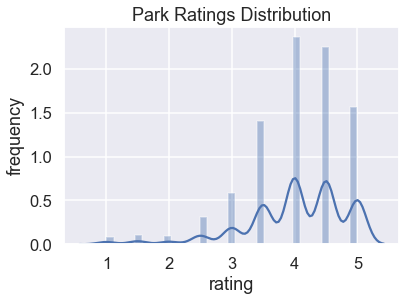

In [10]:
ax = sns.distplot(df['rating'], kde=True)
ax.set_title('Park Ratings Distribution')
ax.set_ylabel('frequency')

Text(0, 0.5, 'frequency')

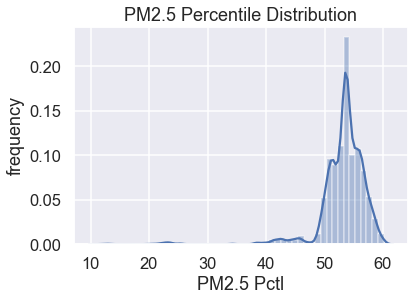

In [11]:
ax = sns.distplot(df['PM2.5 Pctl'], kde=True)
ax.set_title('PM2.5 Percentile Distribution')
ax.set_ylabel('frequency')

Text(0.5, 1.0, 'Relationship between Park Ratings and PM2.5 Pctl')

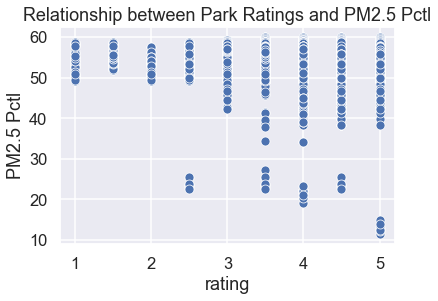

In [12]:
ax = sns.scatterplot(x='rating', y='PM2.5 Pctl', data=df)
ax.set_title('Relationship between Park Ratings and PM2.5 Pctl')

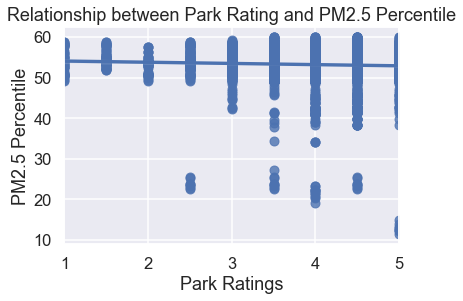

In [13]:
sns.regplot(x="rating", y="PM2.5 Pctl", data=df)

plt.xlabel('Park Ratings')
plt.ylabel('PM2.5 Percentile')
plt.title('Relationship between Park Rating and PM2.5 Percentile')

f5 = plt.gcf()

# Ethics & Privacy

The data in this project are mostly provided for use, so it does not have ethical issues. All works I have done are followed by permissions. In this study, data all come from yelps and California Open Data Portal, which are open for public to access and use. Although the data contain a few information such as parks' addresses, zip codes, phone numbers, they are all public information that allow and hope people to know. So it doesn't involve in any ethical or privacy issues. 

In addition, the data and results might be biased because the study focuses on parks and air quality in San Diego only. The results can not be applied to cities throughout the U.S. or even other countries. However, people can consider the results as a reference for further studies.

# Conclusion & Discussion

In this final project, I use data from yelp ratings and California environmental screening data, trying to figure out any relationship between parks' ratings and PM2.5 percentile around parks in San Diego. Based on the result I got above, it is obvious that there is a slightly negative relation between park ratings and PM2.5 percentile. In other words, the more rating a park gets, the less PM2.5 percentile in air the park has, meaning higher air quality or less air pollution. 

However, some issues also exist in my study. Firstly, my study mainly focuses on measuring PM2.5 percentile in air to examine whether the air quality is good or bad. However, air quality can also be calculated by the factor of ozone concentration, which I didn't include as a criteria in my study. What's more, the relationship between the park ratings and PM2.5 percentiles are not strong, infering that PM2.5 percentiles or even air qualities might not be fully considered as a factor when people did the park ratings.